## M1 - popularity: reductions

### 1. Setup

#### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

from sklearn.linear_model import LinearRegression

sns.set_theme()

#### Functions

In [2]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)
    
    def chroma(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='chroma']
        return self.format(select)

    def mfcc(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='mfcc']
        return self.format(select)

    def tonnetz(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='tonnetz']
        return self.format(select)

fts = Feats('features.csv')

#### Data
For this part of the analysis, we work on fold F2, and subsample 10,000 entries.

In [3]:
# Load fold f2
df_train = pd.read_csv('data/fold/f2_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['release'])
df_test = pd.read_csv('data/fold/f2_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['release'])
print(f'train set: {df_train.shape[0]:,} entries, test set: {df_test.shape[0]:,} entries, total: {df_train.shape[0]+df_test.shape[0]:,} entries')

# Subsample 10,0000 entries from the total train set for reduction analysis
df_red = df_train.sample(n=10000, random_state=1)
df_train, df_test = train_test_split(df_red, test_size=0.2, random_state=1)
print(f'reduction train set: {df_train.shape[0]:,} entries, reduction test set: {df_test.shape[0]:,} entries, reduction total: {df_train.shape[0]+df_test.shape[0]:,} entries')

train set: 68,207 entries, test set: 17,052 entries, total: 85,259 entries
reduction train set: 8,000 entries, reduction test set: 2,000 entries, reduction total: 10,000 entries


### 2. Preprocessing

In [4]:
# Drop NA and zero values
n_orig = df_train.shape[0]
n_na = df_train['popularity'].isna().sum()
df_train = df_train.dropna(subset=['popularity'])
n_zero = df_train.loc[df_train['popularity']==0].shape[0]
df_train = df_train.loc[df_train['popularity']>0]
print(f'Train set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_na = df_test['popularity'].isna().sum()
df_test = df_test.dropna(subset=['popularity'])
n_zero = df_test.loc[df_test['popularity']==0].shape[0]
df_test = df_test.loc[df_test['popularity']>0]
print(f'Test set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_test.shape[0]} entries left.')

Train set: Dropped 0 NA entries and 0 zero entries of 8000, 8000 entries left.
Test set: Dropped 0 NA entries and 0 zero entries of 2000, 2000 entries left.


In [5]:
df_train['popularity']

13762      362
58421     1253
34739      112
11481      384
45107     1104
         ...  
47631     4833
3080       760
1761       396
46162    36983
41459     8626
Name: popularity, Length: 8000, dtype: int64

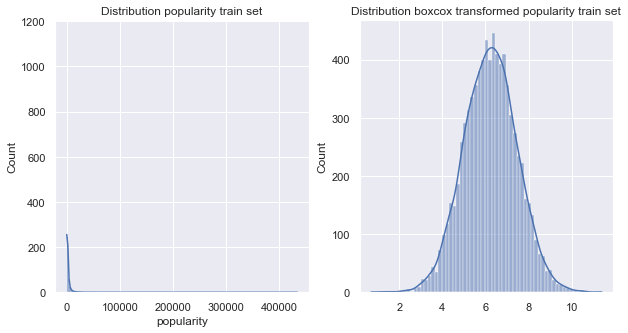

In [6]:
# Boxcox transform y
y_train_before = df_train['popularity']
y_train = stats.boxcox(y_train_before)[0]
y_train = pd.Series(y_train)
y_test_before = df_test['popularity']
y_test = stats.boxcox(y_test_before)[0]
y_test = pd.Series(y_test)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity train set")
ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
ax2.set(title="Distribution boxcox transformed popularity train set")
fig;

In [7]:
# Scale X
X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')


Scaled train X:
	mean: [7.993605777301126e-18, -3.1086244689504384e-18, 3.552713678800501e-18, -6.661338147750939e-18, 2.6645352591003758e-18]...
	std: [1.0000625058599852, 1.0000625058599855, 1.0000625058599852, 1.0000625058599855, 1.0000625058599852]...
Scaled test X:
	mean: [0.017346225099436723, 0.013104071250169292, -0.010279779500762672, -0.008766507774874189, 0.0030267507830802087]...
	std: [0.8173177730192162, 1.1332096116408379, 0.4342778448298038, 1.1365457779142276, 1.1282047076559618]...


### 3. Dimensionality reduction

#### Benchmark

In [8]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_train_bm = round(model.score(X_train, y_train), 6)
r2_test_bm = round(metrics.r2_score(y_test, y_pred), 6)

print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')

Benchmark: Train R2 for all features: 0.189122, Test R2 for all features: 0.049559


#### Grid

In [9]:
fts_sets = {'all':fts.all(), 'first':fts.first(), 'mean':fts.mean(), 'std':fts.std(), 'kurtosis':fts.kurtosis(), 'chroma':fts.chroma(), 'mfcc':fts.mfcc(), 'tonnetz':fts.tonnetz()}
n_components = {'2':2, '10':10, '25':25, '45':45, '70':70, '100':100, '200':250, '300':250, '400':400, '500':518}

#### RFE - random feature elimination
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [10]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            estimator = LinearRegression()
            red = RFE(estimator, n_features_to_select=n, step=5).fit(X_train_fts, y_train)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [11]:
# Keeping all features and no dim reduction results in the highest R2
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189122, Test R2 for all features: 0.049559
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,-0.003718,0.061652,0.073469,0.082492,0.081085,0.067309,0.061006,0.061006,0.055798,0.049559
first,-0.010117,0.033857,0.051728,0.053616,0.054748,nan,nan,nan,nan,nan
mean,-0.004080,0.070065,0.065949,0.066840,0.067768,nan,nan,nan,nan,nan
std,0.010475,0.020755,0.014624,0.017963,0.017307,nan,nan,nan,nan,nan
kurtosis,0.005134,0.047434,0.062389,0.059887,0.062107,nan,nan,nan,nan,nan
chroma,0.016249,0.030852,0.033703,0.022543,0.007048,-0.016763,-0.024126,-0.024126,nan,nan
mfcc,0.004857,0.006497,0.034510,0.048803,0.051350,0.048061,nan,nan,nan,nan
tonnetz,0.020533,0.024660,0.023162,nan,nan,nan,nan,nan,nan,nan


For all start featsets, except for chroma, selecting only 2 features performs worst. All is the most succesful featset to start with, with the mean featset second. The amount of features selected seems more or less most succesful in the lower numbers, around 45.

#### PCA - principal component analysis
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

In [12]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = PCA(n_components=n).fit(X_train_fts)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [13]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189122, Test R2 for all features: 0.049559
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,0.008598,0.024738,0.057048,0.067811,0.066214,0.079490,0.073857,0.075030,0.064668,0.049559
first,-0.004451,0.006448,0.016127,0.029969,0.051012,nan,nan,nan,nan,nan
mean,0.007815,0.030336,0.064179,0.073102,0.070064,nan,nan,nan,nan,nan
std,-0.007458,0.006611,0.017533,0.016778,0.018196,nan,nan,nan,nan,nan
kurtosis,0.012906,0.023459,0.035404,0.051185,0.057006,nan,nan,nan,nan,nan
chroma,0.008185,0.014686,0.024301,0.028733,0.029522,0.018478,-0.031528,-0.031528,nan,nan
mfcc,-0.010701,0.012763,0.041701,0.043267,0.039613,0.046360,nan,nan,nan,nan
tonnetz,0.002588,0.010961,0.017736,nan,nan,nan,nan,nan,nan,nan


Once again, for all featsets except for chroma, reduction to 2 dimensions performs worst. Once again, the all featset performs best, when reducing to a 100 dimensions. This appears to be a clear optimum, with lower or higher amount of dim gradually performing worse. This is applicable to chroma featset as well, except that the highest score is still quite low. Mean featset once again performs second best.

#### KernelPCA - polynomial principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=pca#sklearn.decomposition.KernelPCA)

In [14]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = KernelPCA(n_components=n, kernel='poly', degree=2).fit(X_train_fts, y_train)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [15]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189122, Test R2 for all features: 0.049559
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,-0.014284,0.009772,0.022587,0.041734,0.065806,0.082655,0.077405,0.077405,0.074497,0.054669
first,-0.014255,-0.005282,0.006467,0.019809,0.027831,nan,nan,nan,nan,nan
mean,0.006821,0.029157,0.063990,0.075663,0.080445,nan,nan,nan,nan,nan
std,-0.010913,-0.004520,0.012645,0.014293,0.018730,nan,nan,nan,nan,nan
kurtosis,0.007090,0.028072,0.040305,0.067820,0.070260,nan,nan,nan,nan,nan
chroma,-0.014268,-0.012267,0.012198,0.014504,0.004191,0.000875,-0.059336,-0.059336,nan,nan
mfcc,-0.013507,-0.009055,0.039190,0.053911,0.060058,0.060097,nan,nan,nan,nan
tonnetz,-0.002396,0.004072,0.010732,nan,nan,nan,nan,nan,nan,nan


The image of the results is almost identical to the image of the results of normal linear PCA, while the highest values have increased a bit. It might be interesting to explore kernelPCA with a higher degree than 2, though that might be challenging computation wise. This appears to be, compared to the other methods, the most promising method for feature selection.

#### ISOmap

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap)

In [16]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = Isomap(n_components=n, n_neighbors=10).fit(X_train_fts)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [17]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189122, Test R2 for all features: 0.049559
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,0.007436,0.026954,0.049882,0.050083,0.054205,0.055056,0.037004,0.037004,0.024550,0.013111
first,-0.003451,0.012551,0.013544,0.020354,0.023945,nan,nan,nan,nan,nan
mean,-0.001867,0.029038,0.040126,0.046280,0.047162,nan,nan,nan,nan,nan
std,-0.007350,0.004125,0.000780,0.007448,0.004820,nan,nan,nan,nan,nan
kurtosis,0.014412,0.033256,0.042055,0.041482,0.048444,nan,nan,nan,nan,nan
chroma,0.010466,0.014735,0.019542,0.019228,0.023898,0.023807,0.032813,0.032813,nan,nan
mfcc,-0.009963,0.017076,0.036008,0.037029,0.035320,0.036723,nan,nan,nan,nan
tonnetz,0.002833,0.017369,0.020902,nan,nan,nan,nan,nan,nan,nan


Performance of ISOmap is worst. In this case, for all featsets reduction to only two dimensions performs worst, and higher dimensions perform better, with an optimum for the all featset for 100 dimensions. The mean feat set performs once more second best, while the difference to the other highest values is smaller.